Initialize KAN

In [ ]:
!pip install git+https://github.com/KindXiaoming/pykan.git

  Cloning https://github.com/KindXiaoming/pykan.git to /tmp/pip-req-build-fnst5sqy
  Running command git clone --filter=blob:none --quiet https://github.com/KindXiaoming/pykan.git /tmp/pip-req-build-fnst5sqy
  Resolved https://github.com/KindXiaoming/pykan.git to commit c162d3837d2d44c702dfc5fbb00d951927eff349
  Preparing metadata (setup.py) ... done
  Created wheel for pykan: filename=pykan-0.2.6-py3-none-any.whl size=77499 sha256=fd04ff2cbbb681df2dd732a31bab72787fb927254e4727e839b61860c39a8d3d
  Stored in directory: /tmp/pip-ephem-wheel-cache-bhlrvldo/wheels/47/ca/5a/98124e020f3119f51c17f78738c621c140b7aa803b0feda76e
Successfully built pykan


In [ ]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')


# Navigate to the directory containing your dataset
# Adjust this path to match your Drive's folder structure
dataset_path = '/content/drive/MyDrive'
os.chdir(dataset_path)

# List files in the current directory
print("Files in the dataset directory:")
print(os.listdir())

# Assuming your dataset is in a zip file named 'kc_house_data.zip'
# If the name is different, replace it in the following line
zip_file = 'archive.zip'

# Check if the zip file exists
if zip_file in os.listdir():
    # Unzip the dataset
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall()
    print(f"Successfully unzipped {zip_file}")

    # List files after unzipping
    print("\nFiles after unzipping:")
    print(os.listdir())
else:
    print(f"Error: {zip_file} not found in the current directory.")

# Verify that the CSV file is now available
if 'kc_house_data.csv' in os.listdir():
    print("\nkc_house_data.csv is ready to use.")
else:
    print("\nError: kc_house_data.csv not found after unzipping.")

Mounted at /content/drive
Files in the dataset directory:
['arvt.gdoc', 'arvt_lab2_copy.gdoc', 'Cover Letter_sdfc.gdoc', 'cover_letter_pt.gdoc', 'cover_letter_at.gdoc', 'cover_letter_IP.gdoc', 'cover_letter_SMA.gdoc', 'cl_pic.gdoc', 'arvindh_resume_ctr_rs.pdf', 'cl_pt.gdoc', 'arvindh_resume_me.pdf', 'op_cl.gdoc', 'sdfc_Cl.gdoc', 'arvindh_Resume_ae.pdf', 'house-71.jpg', 'ras_cl.gdoc', 'Team Name.docx', 'cll8.gdoc', 'model.mp4', 'model.sdf', 'vid.mp4', 'vid1.mp4', 'arvindh_Resume_ds.pdf', 'ra_ft.gdoc', 'pra.gdoc', 'ra_cis.gdoc', 'Fast Gradient Sign Method.gslides', 'e.gdoc', 'Colab Notebooks', 'images', 'Untitled document (1).gdoc', 'scm.gdoc', 'dth.gdoc', 'zc.gdoc', 'Copy of SimCLR.gslides', 'ARPA-H ISO Opportunity Kick-Off.docx', 'pdf', 'FY25 Proposal Development Workshop Series Schedule.docx', 'Essay.gdoc', 'Untitled document.gdoc', 'flowers', 'mae.gdoc', 'archive.zip', ' Team6_LastName_PPO_and_TRPO.gdoc', 'figures', 'model', 'kc_house_data.csv', 'best_model.pth']
Successfully unzippe

In [ ]:
from kan import *
torch.set_default_dtype(torch.float64)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[18,7,1], grid=3, k=3, seed=42, device=device)

cuda
checkpoint directory created: ./model
saving model version 0.0


In [ ]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/kc_house_data.csv')

# Preprocess the data
X = data.drop(['price', 'id', 'date'], axis=1)
y = data['price']

# Log transform the target variable
y = np.log1p(y)

# Split the data into train+val and test sets (80-20 split)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split train+val into train and validation sets (87.5-12.5 split, which is 70-10 of the original data)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
class HouseDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.double, device=device)
        self.y = torch.tensor(y.values, dtype=torch.double, device=device).reshape(-1, 1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create dataset instances
train_dataset = HouseDataset(X_train_scaled, y_train)
val_dataset = HouseDataset(X_val_scaled, y_val)
test_dataset = HouseDataset(X_test_scaled, y_test)


Using device: cuda


Plot KAN at initialization

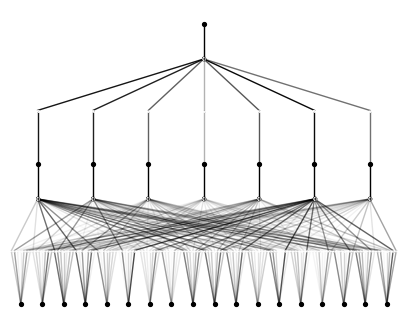

In [ ]:
# plot KAN at initialization
model(train_dataset.X);
model.plot()

In [ ]:
train_dataset_dict = {'train_input': train_dataset.X, 'train_label': train_dataset.y, 'test_input': test_dataset.X, 'test_label':test_dataset.y}


Train KAN with sparsity regularization

In [ ]:
# train the model
model.fit(train_dataset_dict, opt="LBFGS", steps=350, lamb=0.001)

| train_loss: 1.65e-01 | test_loss: 1.76e-01 | reg: 9.18e+00 | : 100%|█| 350/350 [06:19<00:00,  1.08

saving model version 0.1


{'train_loss': [array(0.2268059),
  array(0.19886469),
  array(0.19327547),
  array(0.18885986),
  array(0.18758038),
  array(0.18626859),
  array(0.18410458),
  array(0.18253134),
  array(0.18020255),
  array(0.17808027),
  array(0.17711899),
  array(0.17628316),
  array(0.17568091),
  array(0.17498949),
  array(0.17444233),
  array(0.17430761),
  array(0.17403551),
  array(0.17357281),
  array(0.17335098),
  array(0.17318552),
  array(0.17291979),
  array(0.1726377),
  array(0.17246824),
  array(0.17233312),
  array(0.17216751),
  array(0.17205799),
  array(0.17193582),
  array(0.17182692),
  array(0.17166718),
  array(0.17146823),
  array(0.1713178),
  array(0.17108311),
  array(0.17096658),
  array(0.17083919),
  array(0.17072397),
  array(0.1706954),
  array(0.17057995),
  array(0.17037755),
  array(0.17030073),
  array(0.17015361),
  array(0.16996812),
  array(0.16980979),
  array(0.1694574),
  array(0.16906284),
  array(0.16891293),
  array(0.16893802),
  array(0.16882333),
  ar

Plot trained KAN

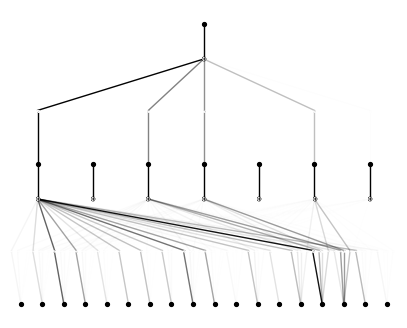

In [ ]:
model.plot()

Prune KAN and replot

saving model version 0.2


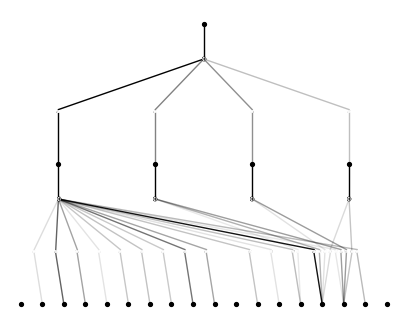

In [ ]:
model = model.prune()
model.plot()

Continue training and replot

In [ ]:
model.fit(train_dataset_dict, opt="LBFGS", steps=50);

| train_loss: 1.72e-01 | test_loss: 1.77e-01 | reg: 1.23e+01 | : 100%|█| 50/50 [00:42<00:00,  1.18it

saving model version 0.3


In [ ]:
model = model.refine(10)

saving model version 0.4


In [ ]:
model.fit(train_dataset_dict, opt="LBFGS", steps=50);

| train_loss: 1.59e-01 | test_loss: 1.70e-01 | reg: 1.17e+01 | : 100%|█| 50/50 [00:52<00:00,  1.05s/

saving model version 0.5


Automatically or manually set activation functions to be symbolic

In [ ]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin');
    model.fix_symbolic(0,1,0,'x^2');
    model.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with 0
fixing (0,0,1) with 0
fixing (0,0,2) with 0
fixing (0,0,3) with 0
fixing (0,1,0) with x, r2=0.8325376511797233, c=1
fixing (0,1,1) with 0
fixing (0,1,2) with 0
fixing (0,1,3) with 0
fixing (0,2,0) with log, r2=0.9960891182789261, c=2
fixing (0,2,1) with 0
fixing (0,2,2) with 0
fixing (0,2,3) with 0
fixing (0,3,0) with x, r2=0.1038996831856973, c=1
fixing (0,3,1) with 0
fixing (0,3,2) with 0
fixing (0,3,3) with 0
fixing (0,4,0) with x, r2=0.988810129285624, c=1
fixing (0,4,1) with 0
fixing (0,4,2) with 0
fixing (0,4,3) with 0
fixing (0,5,0) with x, r2=0.999999999805864, c=1
fixing (0,5,1) with 0
fixing (0,5,2) with 0
fixing (0,5,3) with 0
fixing (0,6,0) with x, r2=0.9829912204964757, c=1
fixing (0,6,1) with 0
fixing (0,6,2) with 0
fixing (0,6,3) with 0
fixing (0,7,0) with x, r2=0.979596307043826, c=1
fixing (0,7,1) with 0
fixing (0,7,2) with 0
fixing (0,7,3) with 0
fixing (0,8,0) with x, r2=0.9968929006560439, c=1
fixing (0,8,1) with 0
fixing (0,8,2) with 0
fixing 

Continue training till machine precision

In [ ]:
model.fit(train_dataset_dict, opt="LBFGS", steps=50);

| train_loss: 2.50e-01 | test_loss: 2.53e-01 | reg: 0.00e+00 | : 100%|█| 50/50 [01:57<00:00,  2.35s/

saving model version 0.7


Obtain the symbolic formula

In [ ]:
from kan.utils import ex_round

ex_round(model.symbolic_formula()[0][0],4)

-0.0056*x_10 - 0.1048*x_12 - 0.0301*x_14 + 0.1951*x_15 - 0.019*x_16 + 0.0647*x_17 + 0.0497*x_2 + 0.0129*x_4 + 0.0399*x_5 + 0.0351*x_6 + 0.0502*x_7 + 0.0382*x_8 + 0.1826*x_9 + 2.0246*(1 - 0.4457*x_13)**2 + 0.6629*log(1.8337*x_3 + 8.3094) + 9.2298

In [ ]:
formula1= model.symbolic_formula()[0][0]


In [ ]:
def mse_loss(formula, X, y):
    batch = X.shape[0]
    correct = 0
    for i in range(batch):
        correct+=(torch.tensor(np.array(formula.subs('x_1', X[i,0]).subs('x_2', X[i,1]).subs('x_3', X[i,2]).subs('x_4', X[i,3]).subs('x_5', X[i,4]).subs('x_6', X[i,5]).subs('x_7', X[i,6]).subs('x_8', X[i,7]).subs('x_9', X[i,8]).subs('x_10', X[i,9]).subs('x_11', X[i,10]).subs('x_12', X[i,11]).subs('x_13', X[i,12]).subs('x_14', X[i,13]).subs('x_15', X[i,14]).subs('x_16', X[i,15]).subs('x_17', X[i,16]).subs('x_18', X[i,17])).astype(np.float64))-y[i,0])**2
    return correct/batch

print('MSE_train', mse_loss(formula1, train_dataset_dict['train_input'], train_dataset_dict['train_label']))
print('MSE_test', mse_loss(formula1, train_dataset_dict['test_input'], train_dataset_dict['test_label']))

MSE_train tensor(0.0624, device='cuda:0')
MSE_test tensor(0.0640, device='cuda:0')
